<a href="https://colab.research.google.com/github/carturo6/Deep_Learning-Covid19/blob/main/LSTM_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I.A. DeepLearnin para Casos Covid-19

Este respositorio tiene el fin de predecir los proximo casos de Covid19 en México ( Nivel nacional ).

Los datos que se ocuparan, son los datos disponibles en paginas del Gobierno.
Se utilizaran solo tecnicas de Deep Learning donde cada modelo podra ir variando en funcion que los datos predichos mejor se ajusten a los datos predictorios.



## **Librerias**

In [1]:
# Import librarys.

# DC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# DL
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras import metrics


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Importacion de datos**

In [2]:
# Carga del Dataset

df = pd.read_csv('/content/drive/MyDrive/IA_Projects/LSTM-Covid-19/owid-covid-data.csv')

In [3]:
# Seleccion a Mexico

df_mx = df[df['location'] == 'Mexico']

df_mx.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45393,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,0.000,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45394,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,97.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45395,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,186.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45396,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,231.0,0.002,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45397,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,316.0,0.002,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779


In [4]:
# Seleccionando columnas
df_mx = df_mx.iloc[:, 3:6]
df_mx.head()

,date,total_cases,new_cases
45393,2020-01-01,NaN,NaN
45394,2020-01-02,NaN,NaN
45395,2020-01-03,NaN,NaN
45396,2020-01-04,NaN,NaN
45397,2020-01-05,NaN,NaN


In [5]:
df_mx = df_mx.reset_index(inplace=False)

In [6]:
del df_mx['index']

In [7]:
# Trabajando con la columna de nuevos casos

df_mx = df_mx.iloc[:,[0,2]]

## **Transformacion de los datos**

In [8]:
df_mx.head(3)

,date,new_cases
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN


In [9]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       454 non-null    object 
 1   new_cases  396 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.2+ KB


In [10]:
df_mx.date = pd.to_datetime(df_mx.date)

In [11]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       454 non-null    datetime64[ns]
 1   new_cases  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 KB


In [12]:
df_mx.describe()

,new_cases
count,396.000000
mean,5625.866162
std,4475.211614
min,0.000000
25%,2800.250000
50%,5237.500000
75%,6848.500000
max,28115.000000


In [13]:
df_mx.isna().sum()

date          0
new_cases    58
dtype: int64

In [14]:
# Quitando Datos faltantes.

df_mx = df_mx[df_mx['new_cases'].notna()]

In [15]:
df_mx.tail()

,date,new_cases
449,2021-03-25,5787.0
450,2021-03-26,5303.0
451,2021-03-27,5059.0
452,2021-03-28,1646.0
453,2021-03-29,1293.0


In [16]:
df_mx.date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     396
unique                    396
top       2020-04-13 00:00:00
freq                        1
first     2020-02-28 00:00:00
last      2021-03-29 00:00:00
Name: date, dtype: object

## **Visualizacion de Datos**

In [17]:
df_mx_2 = df_mx.copy()

In [18]:
df_mx_2.set_index('date', inplace=True)

In [19]:
# Promedio de ventanas de tiempo

#Ventana de tiempo
ventana_tiempo = df_mx_2.rolling(7)

#Media de la ventana de tiempo
media_df = ventana_tiempo.mean()

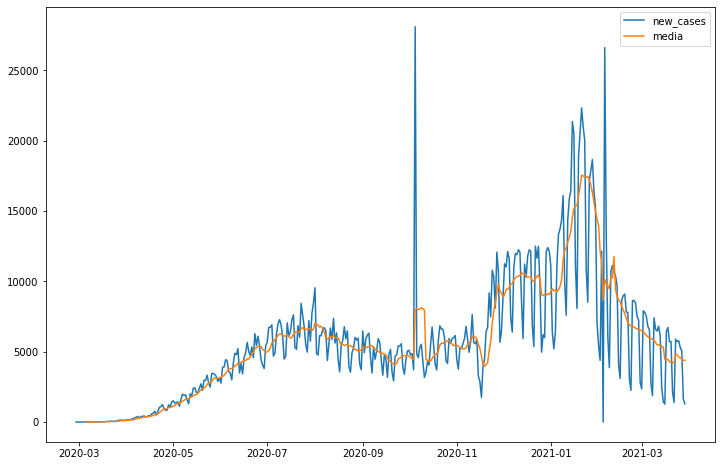

In [20]:
plt.figure(figsize=(12,8))
plt.plot(df_mx_2, label='new_cases')
plt.plot(media_df, label='media')
plt.legend()

In [21]:
seasonal_value = seasonal_decompose(df_mx_2, freq=7)

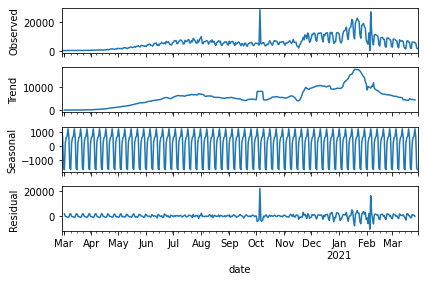

In [22]:
seasonal_value.plot();

# **Modelo-1**

In [23]:
# Datos de entreamiento y test

len(df_mx_2)

396

In [24]:
len(df_mx_2)-20

376

In [25]:
train = df_mx_2.iloc[:len(df_mx_2)-20]
test = df_mx_2.iloc[len(df_mx_2)-20:]

In [26]:
# Escalando datos

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

scaler = MinMaxScaler()

In [27]:
#Ajustando los datos de entrenamiento
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [28]:
#Datos escalados

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [29]:
# Generator
n_input = 20
n_feacture = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

x, y = generator[0]

In [30]:
# Red neuronal

#Red sequential
model_1 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_1.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_1.add(Dense(64, activation='relu' ))
model_1.add(Dense(32))
model_1.add(Dense(1))

#Compilacion de la red nueronal
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Entrenando la red nueronal

model_1.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 4s 15ms/step - loss: 0.0129
Epoch 2/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0138
Epoch 3/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0074
Epoch 4/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0133
Epoch 5/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0145
Epoch 6/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0074
Epoch 7/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0107
Epoch 8/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0112
Epoch 9/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0096
Epoch 10/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0118
Epoch 11/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0083
Epoch 12/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0171
Epoch 13/100


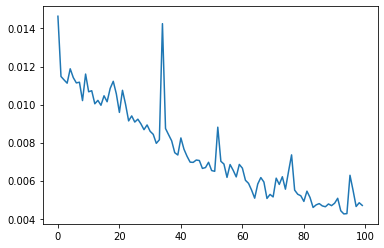

In [33]:
loss_pre_epoch = model_1.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

In [34]:
first_eval = scaled_train[-20:]


first_eval = first_eval.reshape(1, n_input, n_feacture)

model_1.predict(first_eval)

array([[0.28872752]], dtype=float32)

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_1.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [36]:
#Transofmacion inversa
true_predicctions = scaler.inverse_transform(test_predictions)


test['Prediction'] = true_predicctions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


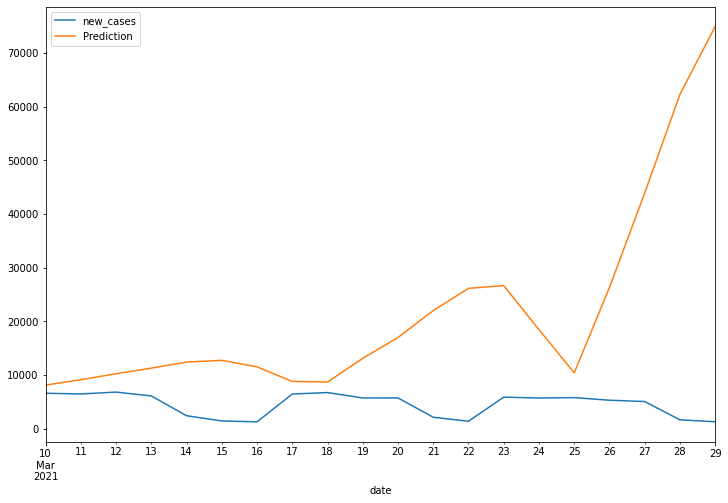

In [37]:
test.plot(figsize=(12,8))

In [38]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction
date,,
2021-03-10,6602.0,8117.574278
2021-03-11,6469.0,9129.992834
2021-03-12,6816.0,10234.787339
2021-03-13,6104.0,11280.778563
2021-03-14,2415.0,12408.137508
2021-03-15,1439.0,12728.028866
2021-03-16,1278.0,11513.550908
2021-03-17,6455.0,8803.365660
2021-03-18,6726.0,8685.789261


# **Modelo 2**

In [39]:
# Red neuronal 2
# 5 Capas
# relu para activacion de cada capa
# sgd para compilacion y mse para loss

#Red sequential
model_2 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_2.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_2.add(Dense(64, activation='relu' ))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(12))
model_2.add(Dense(1))

#Compilacion de la red nueronal
model_2.compile(optimizer='sgd', loss='mean_squared_error', )

In [40]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                396       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
Total params: 77,305
Trainable params: 77,305
Non-trainable params: 0
_________________________________________________________________


In [41]:
#Entrenando la red nueronal

model_2.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 4s 15ms/step - loss: 0.0341
Epoch 2/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0210
Epoch 3/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0182
Epoch 4/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0158
Epoch 5/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0182
Epoch 6/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0186
Epoch 7/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0147
Epoch 8/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0115
Epoch 9/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0100
Epoch 10/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0099
Epoch 11/100
178/178 [==============================] - 3s 15ms/step - loss: 0.0087
Epoch 12/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0093
Epoch 13/100


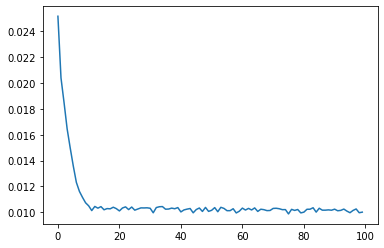

In [42]:
loss_pre_epoch = model_2.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

In [43]:
first_eval = scaled_train[-20:]


first_eval = first_eval.reshape(1, n_input, n_feacture)

model_2.predict(first_eval)

array([[0.20953481]], dtype=float32)

In [44]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_2.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [45]:
#Transofmacion inversa
true_predicctions_2 = scaler.inverse_transform(test_predictions)


test['Prediction_2'] = true_predicctions_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


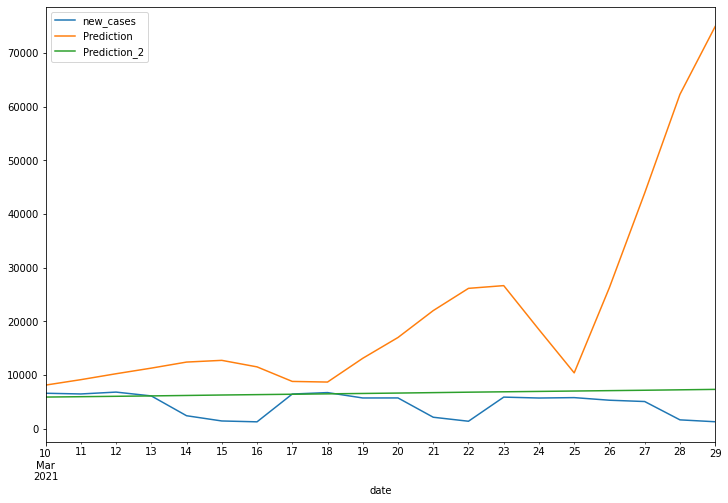

In [46]:
test.plot(figsize=(12,8))

In [47]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2
date,,,
2021-03-10,6602.0,8117.574278,5891.071155
2021-03-11,6469.0,9129.992834,5959.243748
2021-03-12,6816.0,10234.787339,6032.689197
2021-03-13,6104.0,11280.778563,6106.416178
2021-03-14,2415.0,12408.137508,6188.936838
2021-03-15,1439.0,12728.028866,6272.836669
2021-03-16,1278.0,11513.550908,6344.789413
2021-03-17,6455.0,8803.365660,6416.479478
2021-03-18,6726.0,8685.789261,6488.343405


# **Modeo 3**

In [48]:
# Red neuronal 3
# 5 Capas
# relu para activacion de cada capa
# sgd para compilacion y mse para loss

#Red sequential
model_3 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_3.add(LSTM(168, activation='relu', input_shape=(n_input, n_feacture)))
model_3.add(Dense(124, activation='relu' ))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32))
model_3.add(Dense(1))

#Compilacion de la red nueronal
model_3.compile(optimizer='sgd', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [49]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 168)               114240    
_________________________________________________________________
dense_7 (Dense)              (None, 124)               20956     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8000      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 145,309
Trainable params: 145,309
Non-trainable params: 0
_________________________________________________________________


In [50]:
#Entrenando la red nueronal

model_3.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 5s 20ms/step - loss: 0.0297 - mean_absolute_error: 0.1162 - categorical_accuracy: 1.0000
Epoch 2/100
178/178 [==============================] - 4s 20ms/step - loss: 0.0220 - mean_absolute_error: 0.1061 - categorical_accuracy: 1.0000
Epoch 3/100
178/178 [==============================] - 3s 19ms/step - loss: 0.0210 - mean_absolute_error: 0.1006 - categorical_accuracy: 1.0000
Epoch 4/100
178/178 [==============================] - 4s 20ms/step - loss: 0.0164 - mean_absolute_error: 0.0861 - categorical_accuracy: 1.0000
Epoch 5/100
178/178 [==============================] - 4s 20ms/step - loss: 0.0114 - mean_absolute_error: 0.0748 - categorical_accuracy: 1.0000
Epoch 6/100
178/178 [==============================] - 4s 20ms/step - loss: 0.0092 - mean_absolute_error: 0.0658 - categorical_accuracy: 1.0000
Epoch 7/100
178/178 [==============================] - 3s 20ms/step - loss: 0.0090 - mean_absolute_error: 0.0670 - categorical_accuracy: 1.0000
Epoc

In [51]:
first_eval_3 = scaled_train[-20:]


first_eval_3 = first_eval_3.reshape(1, n_input, n_feacture)

model_3.predict(first_eval_3)

array([[0.21077415]], dtype=float32)

In [52]:
test_predictions_3 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_3.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_3.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_3.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
#Transofmacion inversa
true_predicctions_3 = scaler.inverse_transform(test_predictions_3)


test['Prediction_3'] = true_predicctions_3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


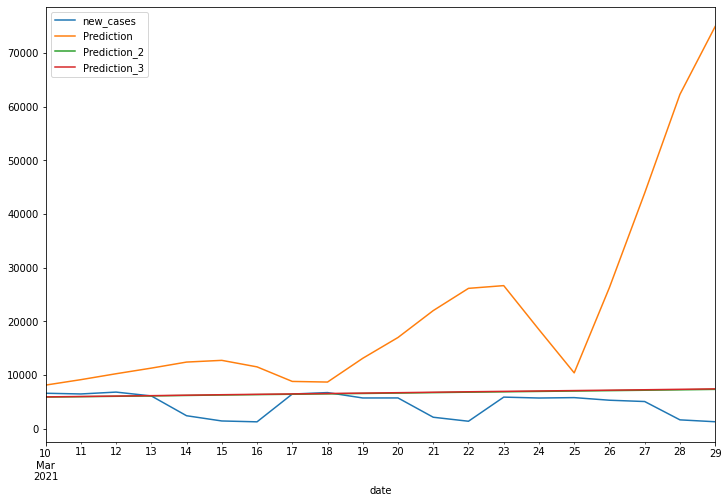

In [54]:
test.plot(figsize=(12,8))

In [55]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3
date,,,,
2021-03-10,6602.0,8117.574278,5891.071155,5925.915325
2021-03-11,6469.0,9129.992834,5959.243748,5998.956910
2021-03-12,6816.0,10234.787339,6032.689197,6076.050123
2021-03-13,6104.0,11280.778563,6106.416178,6152.986231
2021-03-14,2415.0,12408.137508,6188.936838,6239.470122
2021-03-15,1439.0,12728.028866,6272.836669,6327.561510
2021-03-16,1278.0,11513.550908,6344.789413,6402.411266
2021-03-17,6455.0,8803.365660,6416.479478,6477.095958
2021-03-18,6726.0,8685.789261,6488.343405,6552.127537


# **Modelo 4**

In [56]:
# Red neuronal 4
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_4 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_4.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_4.add(Dense(100, activation='relu' ))
model_4.add(Dense(84, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(32))
model_4.add(Dense(1))

#Compilacion de la red nueronal
model_4.compile(optimizer='adam', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [57]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_12 (Dense)             (None, 84)                8484      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2720      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 193,993
Trainable params: 193,993
Non-trainable params: 0
________________________________________________

In [58]:
#Entrenando la red nueronal

model_4.fit_generator(generator, epochs=200)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 6s 25ms/step - loss: 0.0246 - mean_absolute_error: 0.1120 - categorical_accuracy: 1.0000
Epoch 2/200
178/178 [==============================] - 4s 25ms/step - loss: 0.0123 - mean_absolute_error: 0.0720 - categorical_accuracy: 1.0000
Epoch 3/200
178/178 [==============================] - 5s 25ms/step - loss: 0.0107 - mean_absolute_error: 0.0691 - categorical_accuracy: 1.0000
Epoch 4/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0160 - mean_absolute_error: 0.0853 - categorical_accuracy: 1.0000
Epoch 5/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0171 - mean_absolute_error: 0.0869 - categorical_accuracy: 1.0000
Epoch 6/200
178/178 [==============================] - 5s 25ms/step - loss: 0.0163 - mean_absolute_error: 0.0817 - categorical_accuracy: 1.0000
Epoch 7/200
178/178 [==============================] - 4s 24ms/step - loss: 0.0156 - mean_absolute_error: 0.0766 - categorical_accuracy: 1.0000
Epoc

In [59]:
first_eval_4 = scaled_train[-20:]


first_eval_4 = first_eval_4.reshape(1, n_input, n_feacture)

model_4.predict(first_eval_4)

array([[0.2307695]], dtype=float32)

In [60]:
test_predictions_4 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_4.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_4.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_4.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [61]:
#Transofmacion inversa
true_predicctions_4 = scaler.inverse_transform(test_predictions_4)


test['Prediction_4'] = true_predicctions_4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


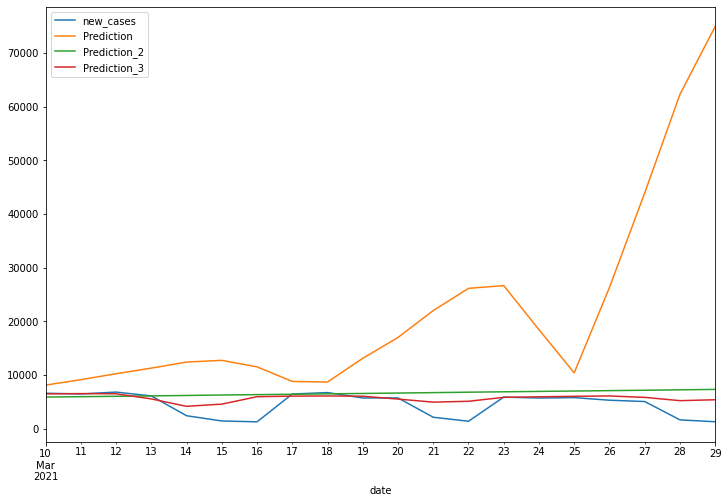

In [62]:
test.plot(figsize=(12,8))

In [63]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3
date,,,,
2021-03-10,6602.0,8117.574278,5891.071155,6488.084496
2021-03-11,6469.0,9129.992834,5959.243748,6534.763895
2021-03-12,6816.0,10234.787339,6032.689197,6500.475248
2021-03-13,6104.0,11280.778563,6106.416178,5548.327542
2021-03-14,2415.0,12408.137508,6188.936838,4167.015173
2021-03-15,1439.0,12728.028866,6272.836669,4574.033923
2021-03-16,1278.0,11513.550908,6344.789413,5957.935379
2021-03-17,6455.0,8803.365660,6416.479478,6068.575705
2021-03-18,6726.0,8685.789261,6488.343405,6095.984837


# **Model 5**

In [64]:
# Red neuronal 5
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_5 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_5.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_5.add(Dense(100, activation='relu' ))
model_5.add(Dense(84, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='sigmoid'))
model_5.add(Dense(1))

#Compilacion de la red nueronal
model_5.compile(optimizer='adam', loss='mean_squared_error',
                metrics=["accuracy"])

In [65]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_16 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_17 (Dense)             (None, 84)                8484      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                5440      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 197,737
Trainable params: 197,737
Non-trainable params: 0
________________________________________________

In [66]:
#Entrenando la red nueronal

model_5.fit_generator(generator, epochs=200)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 6s 25ms/step - loss: 0.0297 - accuracy: 4.0101e-04
Epoch 2/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0125 - accuracy: 0.0041
Epoch 3/200
178/178 [==============================] - 5s 25ms/step - loss: 0.0124 - accuracy: 0.0037
Epoch 4/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0097 - accuracy: 0.0024
Epoch 5/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0122 - accuracy: 0.0027
Epoch 6/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0141 - accuracy: 7.8999e-05
Epoch 7/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0126 - accuracy: 6.8435e-04
Epoch 8/200
178/178 [==============================] - 5s 26ms/step - loss: 0.0144 - accuracy: 0.0033
Epoch 9/200
178/178 [==============================] - 4s 24ms/step - loss: 0.0083 - accuracy: 4.3717e-04
Epoch 10/200
178/178 [==============================] - 4s 24ms/step - loss: 0

In [67]:
first_eval_5 = scaled_train[-20:]


first_eval_5 = first_eval_5.reshape(1, n_input, n_feacture)

model_5.predict(first_eval_5)

array([[0.18385735]], dtype=float32)

In [68]:
test_predictions_5 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_5.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_5.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_5.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [69]:
#Transofmacion inversa
true_predicctions_5 = scaler.inverse_transform(test_predictions_5)


test['Prediction_5'] = true_predicctions_5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


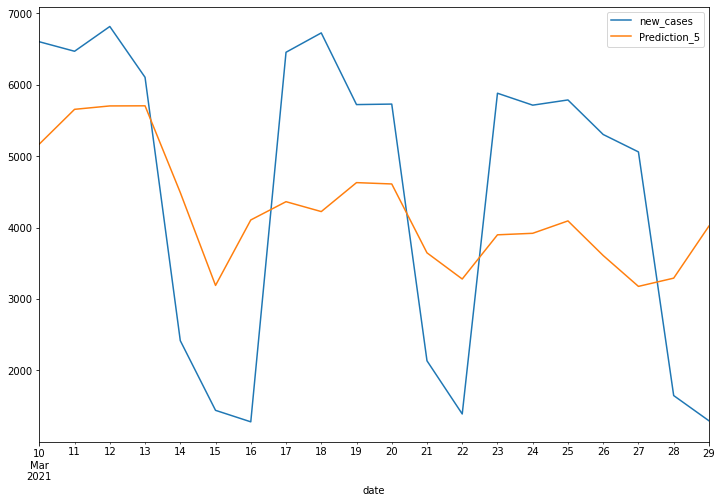

In [70]:
test[['new_cases', 'Prediction_5']].plot(figsize=(12,8))

In [71]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3,Prediction_5
date,,,,,
2021-03-10,6602.0,8117.574278,5891.071155,6488.084496,5169.149439
2021-03-11,6469.0,9129.992834,5959.243748,6534.763895,5655.546753
2021-03-12,6816.0,10234.787339,6032.689197,6500.475248,5703.138198
2021-03-13,6104.0,11280.778563,6106.416178,5548.327542,5704.762452
2021-03-14,2415.0,12408.137508,6188.936838,4167.015173,4489.504835
2021-03-15,1439.0,12728.028866,6272.836669,4574.033923,3188.826193
2021-03-16,1278.0,11513.550908,6344.789413,5957.935379,4105.755192
2021-03-17,6455.0,8803.365660,6416.479478,6068.575705,4361.793710
2021-03-18,6726.0,8685.789261,6488.343405,6095.984837,4223.233556


# **Modelo 6**

In [72]:
# Red neuronal 6
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_6 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_6.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_6.add(Dense(150, activation='relu' ))
model_6.add(Dense(100, activation='relu'))
model_6.add(Dense(80, activation='relu'))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='sigmoid'))
model_6.add(Dense(1))

#Compilacion de la red nueronal
model_6.compile(optimizer='adam', loss='mean_squared_error',
                metrics=["accuracy"])

In [73]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_21 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_23 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                5184      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                

In [74]:
#Entrenando la red nueronal

model_6.fit_generator(generator, epochs=250)

Epoch 1/250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 6s 25ms/step - loss: 0.1481 - accuracy: 0.0097
Epoch 2/250
178/178 [==============================] - 4s 25ms/step - loss: 0.0126 - accuracy: 0.0027
Epoch 3/250
178/178 [==============================] - 4s 25ms/step - loss: 0.0124 - accuracy: 0.0012
Epoch 4/250
178/178 [==============================] - 4s 25ms/step - loss: 0.0114 - accuracy: 0.0013
Epoch 5/250
178/178 [==============================] - 4s 24ms/step - loss: 0.0100 - accuracy: 4.7380e-04
Epoch 6/250
178/178 [==============================] - 4s 24ms/step - loss: 0.0103 - accuracy: 0.0047
Epoch 7/250
178/178 [==============================] - 4s 24ms/step - loss: 0.0102 - accuracy: 0.0033
Epoch 8/250
178/178 [==============================] - 4s 24ms/step - loss: 0.0139 - accuracy: 0.0040
Epoch 9/250
178/178 [==============================] - 4s 24ms/step - loss: 0.0131 - accuracy: 0.0043
Epoch 10/250
178/178 [==============================] - 4s 24ms/step - loss: 0.0186 - accu

In [75]:
first_eval_6 = scaled_train[-20:]


first_eval_6 = first_eval_6.reshape(1, n_input, n_feacture)

model_6.predict(first_eval_6)

array([[0.23784475]], dtype=float32)

In [76]:
test_predictions_6 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_6.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_6.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_6.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [77]:
#Transofmacion inversa
true_predicctions_6 = scaler.inverse_transform(test_predictions_6)


test['Prediction_6'] = true_predicctions_6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


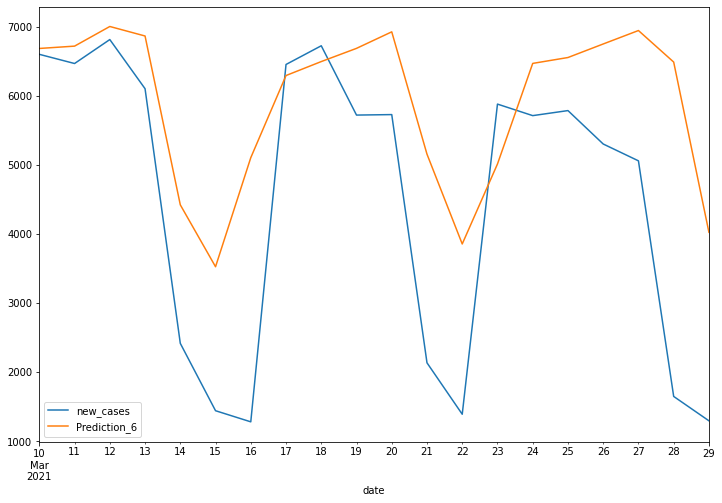

In [82]:
test[['new_cases', 'Prediction_6']].plot(figsize=(12,8))

In [79]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3,Prediction_5,Prediction_6
date,,,,,,
2021-03-10,6602.0,8117.574278,5891.071155,6488.084496,5169.149439,6687.005154
2021-03-11,6469.0,9129.992834,5959.243748,6534.763895,5655.546753,6720.818717
2021-03-12,6816.0,10234.787339,6032.689197,6500.475248,5703.138198,7005.366102
2021-03-13,6104.0,11280.778563,6106.416178,5548.327542,5704.762452,6867.594824
2021-03-14,2415.0,12408.137508,6188.936838,4167.015173,4489.504835,4421.883156
2021-03-15,1439.0,12728.028866,6272.836669,4574.033923,3188.826193,3524.770311
2021-03-16,1278.0,11513.550908,6344.789413,5957.935379,4105.755192,5104.688290
2021-03-17,6455.0,8803.365660,6416.479478,6068.575705,4361.793710,6294.898373
2021-03-18,6726.0,8685.789261,6488.343405,6095.984837,4223.233556,6497.188615
